In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time

In [16]:
# Set random seed
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [17]:
# Configuration
DATASET = 'CIFAR100'  # Change to 'CIFAR100' for CIFAR-100
NUM_CLASSES = 10 if DATASET == 'CIFAR10' else 100
NUM_EPOCHS = 15 if DATASET == 'CIFAR10' else 25

print(f"Training ResNet-18 on {DATASET}")

Training ResNet-18 on CIFAR100


In [18]:
# Data preprocessing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load dataset
print(f"Loading {DATASET} dataset...")
if DATASET == 'CIFAR10':
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
else:
    trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

print(f"Training samples: {len(trainset)}")
print(f"Test samples: {len(testset)}")

Loading CIFAR100 dataset...
Files already downloaded and verified
Files already downloaded and verified
Training samples: 50000
Test samples: 10000


In [19]:
# ResNet Basic Block
class BasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # Skip connection - KEY INNOVATION!
        out = F.relu(out)
        return out

# ResNet-18 Architecture
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        
        # Initial conv layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # ResNet layers
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        # Final classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
        # Initialize weights
        self._initialize_weights()
    
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

In [20]:
# Initialize model
model = ResNet18(num_classes=NUM_CLASSES).to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [21]:
# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Total parameters: 11,220,132
Trainable parameters: 11,220,132


In [22]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)

# Training function
def train_epoch(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        if batch_idx % 100 == 0:
            print(f'Batch {batch_idx}/{len(trainloader)}, Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')
    
    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Evaluation function
def evaluate(model, testloader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    test_loss /= len(testloader)
    test_acc = 100. * correct / total
    return test_loss, test_acc

In [23]:
# Training loop
print(f"\nStarting ResNet-18 training on {DATASET}...")
train_losses, train_accs = [], []
test_losses, test_accs = [], []
learning_rates = []

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f'\nEpoch {epoch+1}/{NUM_EPOCHS}')
    print('-' * 50)
    
    # Train
    train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device)
    
    # Evaluate
    test_loss, test_acc = evaluate(model, testloader, criterion, device)
    
    # Step scheduler
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    
    # Store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    print(f'Learning Rate: {current_lr:.6f}')

total_time = time.time() - start_time
print(f'\nTraining completed in {total_time:.2f} seconds')


Starting ResNet-18 training on CIFAR100...

Epoch 1/25
--------------------------------------------------
Batch 0/391, Loss: 4.6401, Acc: 0.00%
Batch 100/391, Loss: 3.9847, Acc: 4.22%
Batch 200/391, Loss: 3.9146, Acc: 5.96%
Batch 300/391, Loss: 3.6658, Acc: 7.38%
Train Loss: 3.9892, Train Acc: 8.44%
Test Loss: 3.6303, Test Acc: 13.75%
Learning Rate: 0.100000

Epoch 2/25
--------------------------------------------------
Batch 0/391, Loss: 3.5996, Acc: 15.62%
Batch 100/391, Loss: 3.5253, Acc: 14.61%
Batch 200/391, Loss: 3.4749, Acc: 16.01%
Batch 300/391, Loss: 3.2337, Acc: 17.14%
Train Loss: 3.3400, Train Acc: 18.36%
Test Loss: 3.2809, Test Acc: 20.70%
Learning Rate: 0.100000

Epoch 3/25
--------------------------------------------------
Batch 0/391, Loss: 3.0140, Acc: 20.31%
Batch 100/391, Loss: 2.7593, Acc: 25.32%
Batch 200/391, Loss: 2.7273, Acc: 26.37%
Batch 300/391, Loss: 2.4159, Acc: 27.56%
Train Loss: 2.7793, Train Acc: 28.54%
Test Loss: 2.6023, Test Acc: 32.64%
Learning Rate: 0

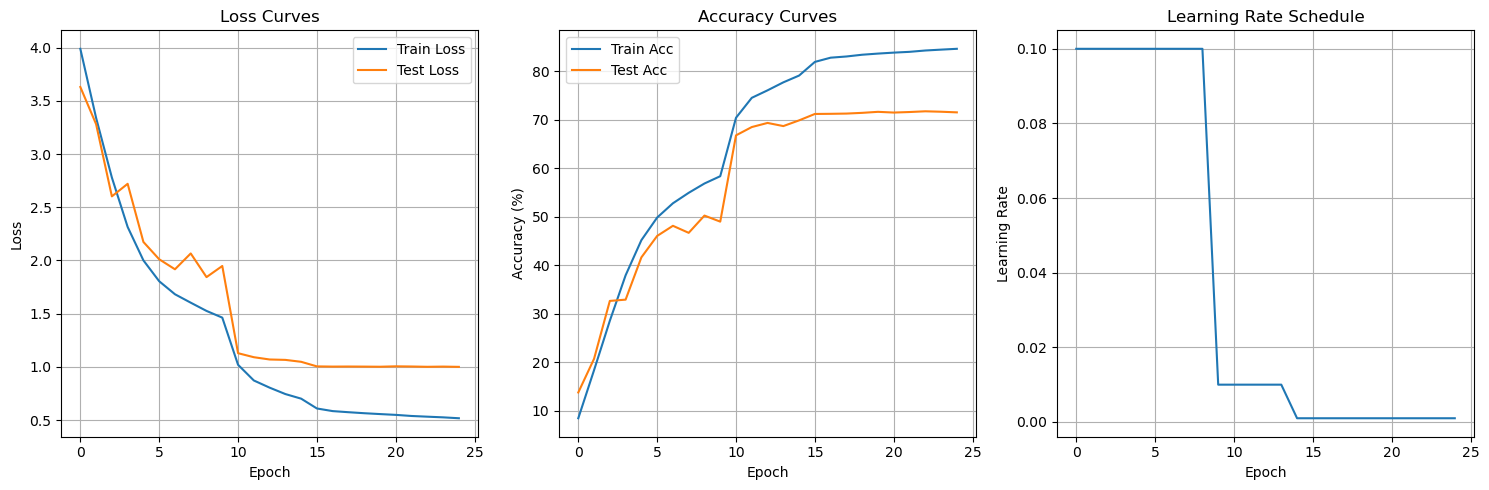

In [24]:
# Plot training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(learning_rates)
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)

plt.tight_layout()
plt.show()

In [25]:
# Final results summary
print(f"\n" + "="*60)
print(f"ResNet-18 on {DATASET} Results Summary")
print("="*60)
print(f"Final Train Accuracy: {train_accs[-1]:.2f}%")
print(f"Final Test Accuracy: {test_accs[-1]:.2f}%")
print(f"Best Test Accuracy: {max(test_accs):.2f}%")
print(f"Total Parameters: {total_params:,}")
print(f"Total Epochs: {NUM_EPOCHS}")
print(f"Training Time: {total_time:.2f} seconds")
print(f"Overfitting Gap: {train_accs[-1] - test_accs[-1]:.2f}%")


ResNet-18 on CIFAR100 Results Summary
Final Train Accuracy: 84.64%
Final Test Accuracy: 71.53%
Best Test Accuracy: 71.75%
Total Parameters: 11,220,132
Total Epochs: 25
Training Time: 893.19 seconds
Overfitting Gap: 13.11%


In [26]:
# Comparison with previous results
print(f"\n" + "="*60)
print(f"COMPARISON: Previous CNN vs ResNet-18 on {DATASET}")
print("="*60)
if DATASET == 'CIFAR10':
    print(f"Deeper CNN Test Accuracy:  86.45%")
    print(f"ResNet-18 Test Accuracy:   {max(test_accs):.2f}%")
    print(f"Improvement: {max(test_accs) - 86.45:+.2f}%")
    print(f"Deeper CNN Parameters:     7,320,394")
else:
    print(f"Deeper CNN Test Accuracy:  53.57%")
    print(f"ResNet-18 Test Accuracy:   {max(test_accs):.2f}%")
    print(f"Improvement: {max(test_accs) - 53.57:+.2f}%")
    print(f"Deeper CNN Parameters:     7,366,564")

print(f"ResNet-18 Parameters:      {total_params:,}")
print(f"Parameter Efficiency: {total_params / 7320394:.2f}x")


COMPARISON: Previous CNN vs ResNet-18 on CIFAR100
Deeper CNN Test Accuracy:  53.57%
ResNet-18 Test Accuracy:   71.75%
Improvement: +18.18%
Deeper CNN Parameters:     7,366,564
ResNet-18 Parameters:      11,220,132
Parameter Efficiency: 1.53x
